In [14]:
from __future__ import absolute_import
import matplotlib.pyplot as plt
import tifffile as tif
from cv2 import cv2
import numpy as np
import glob
from tensorflow import keras
from tensorflow.keras.layers import Input, GlobalAveragePooling1D
from tensorflow.keras.layers import Dense
import swin_layers
import transformer_layers


In [15]:
def resize_image(img, size=(28,28)):
    h, w = img.shape[:2]
    c = img.shape[2] if len(img.shape)>2 else 1

    if h == w:
        return cv2.resize(img, size, cv2.INTER_AREA)

    dif = h if h > w else w

    interpolation = cv2.INTER_AREA if dif > (size[0]+size[1])//2 else cv2.INTER_CUBIC

    x_pos = (dif - w)//2
    y_pos = (dif - h)//2

    if len(img.shape) == 2:
        mask = np.zeros((dif, dif), dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w] = img[:h, :w]
    else:
        mask = np.zeros((dif, dif, c), dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w, :] = img[:h, :w, :]

    return cv2.resize(mask, size, interpolation)

In [16]:
xtrain_list = glob.glob('G:/深度学习数据集/SAR图像/trainData/croped_train/*.jpg')
x_train=np.array([np.array(cv2.resize(tif.imread(fname),(28,28))) for fname in xtrain_list])

xtest_list = glob.glob('G:/深度学习数据集/SAR图像/trainData/croped_test/*.jpg')
x_test=np.array([np.array(cv2.resize(tif.imread(fname),(28,28))) for fname in xtest_list])

#plt.imshow(cv2.resize(tif.imread('G:/深度学习数据集/SAR图像/trainData/croped_test/3.jpg'),(28,28)))
#plt.show()
y_file= open('G:/深度学习数据集/SAR图像/trainData/swin_classification_train.txt')
y_train=np.zeros((5243),dtype=np.int8)
for i in range(0,5243):
    y_train[i] = int(y_file.readline())

y_file= open('G:/深度学习数据集/SAR图像/trainData/swin_classification_test.txt')
y_test=np.zeros((938),dtype=np.int8)
for i in range(0,938):
    y_test[i] = int(y_file.readline())

In [17]:
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

y_train = keras.utils.to_categorical(y_train, 7)
y_test = keras.utils.to_categorical(y_test, 7)

input_size = (28, 28, 1) # The image size of the MNIST
patch_size = (2, 2) # Segment 28-by-28 frames into 2-by-2 sized patches, patch contents and positions are embedded
n_labels = 7 # MNIST labels

# Dropout parameters
mlp_drop_rate = 0.01 # Droupout after each MLP layer
attn_drop_rate = 0.01 # Dropout after Swin-Attention
proj_drop_rate = 0.01 # Dropout at the end of each Swin-Attention block, i.e., after linear projections
drop_path_rate = 0.01 # Drop-path within skip-connections

# Self-attention parameters
# (Fixed for all the blocks in this configuration, but can vary per block in larger architectures)
num_heads = 8 # Number of attention heads
embed_dim = 64 # Number of embedded dimensions
num_mlp = 256 # Number of MLP nodes
qkv_bias = True # Convert embedded patches to query, key, and values with a learnable additive value
qk_scale = None # None: Re-scale query based on embed dimensions per attention head # Float for user specified scaling factor

# Shift-window parameters
window_size = 2 # Size of attention window (height = width)
shift_size = window_size // 2 # Size of shifting (shift_size < window_size)

num_patch_x = input_size[0]//patch_size[0]
num_patch_y = input_size[1]//patch_size[1]

# The input section
IN = Input(input_size)
X = IN

# Extract patches from the input tensor
X = transformer_layers.patch_extract(patch_size)(X)

# Embed patches to tokens
X = transformer_layers.patch_embedding(num_patch_x * num_patch_y, embed_dim)(X)

# -------------------- Swin transformers -------------------- #
# Stage 1: window-attention + Swin-attention + patch-merging

for i in range(2):

    if i % 2 == 0:
        shift_size_temp = 0
    else:
        shift_size_temp = shift_size

    X = swin_layers.SwinTransformerBlock(dim=embed_dim, num_patch=(num_patch_x, num_patch_y), num_heads=num_heads,
                                         window_size=window_size, shift_size=shift_size_temp, num_mlp=num_mlp,
                                         qkv_bias=qkv_bias, qk_scale=qk_scale,
                                         mlp_drop=mlp_drop_rate, attn_drop=attn_drop_rate, proj_drop=proj_drop_rate,
                                         drop_path_prob=drop_path_rate,
                                         name='swin_block{}'.format(i))(X)
# Patch-merging
#    Pooling patch sequences. Half the number of patches (skip every two patches) and double the embedded dimensions
X = transformer_layers.patch_merging((num_patch_x, num_patch_y), embed_dim=embed_dim, name='down{}'.format(i))(X)

# ----------------------------------------------------------- #

# Convert embedded tokens (2D) to vectors (1D)
X = GlobalAveragePooling1D()(X)

# The output section
OUT = Dense(n_labels, activation='softmax')(X)

model = keras.models.Model(inputs=[IN,], outputs=[OUT,])
model.summary()

opt = keras.optimizers.Adam(learning_rate=1e-4, clipvalue=0.5)
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy',])


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 patch_extract_3 (patch_extr  (None, 196, 4)           0         
 act)                                                            
                                                                 
 patch_embedding_3 (patch_em  (None, 196, 64)          12864     
 bedding)                                                        
                                                                 
 swin_transformer_block_6 (S  (None, 196, 64)          50072     
 winTransformerBlock)                                            
                                                                 
 swin_transformer_block_7 (S  (None, 196, 64)          50856     
 winTransformerBlock)                                      

In [19]:
history = model.fit(x_train, y_train, batch_size=32, epochs=5, validation_split=0.1)

Epoch 1/5
148/148 [==============================] - 7s 30ms/step - loss: 1.8087 - accuracy: 0.4069 - val_loss: 1.7741 - val_accuracy: 0.4543
Epoch 2/5
148/148 [==============================] - 4s 26ms/step - loss: 1.5497 - accuracy: 0.5315 - val_loss: 1.6445 - val_accuracy: 0.5167
Epoch 3/5
148/148 [==============================] - 4s 26ms/step - loss: 1.3412 - accuracy: 0.6345 - val_loss: 1.4356 - val_accuracy: 0.6133
Epoch 4/5
148/148 [==============================] - 4s 26ms/step - loss: 1.1397 - accuracy: 0.7347 - val_loss: 1.2285 - val_accuracy: 0.7243
Epoch 5/5
148/148 [==============================] - 4s 26ms/step - loss: 0.7339 - accuracy: 0.8364 - val_loss: 0.7295 - val_accuracy: 0.8543


In [21]:
loss,acc=model.evaluate(x_test,y_test)

30/30 [==============================] - 0s 9ms/step - loss: 0.7155 - accuracy: 0.8621


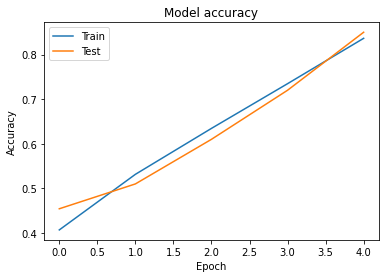

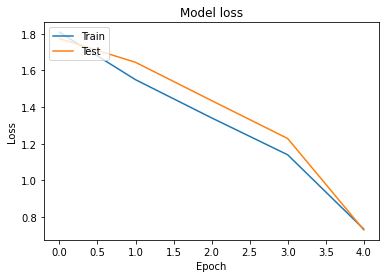

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 绘制训练 & 验证的损失值
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()